In [4]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow # For showing because cv2.imshow doesn't work normally
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import signal

In [5]:
# https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/criminisi_cvpr2003.pdf

In [6]:
test_image = cv2.imread('image1.jpg', cv2.IMREAD_COLOR)
test_mask = cv2.imread('mask1.jpg', cv2.IMREAD_GRAYSCALE)

In [86]:
class inpainting():
  def __init__(self, image, mask):
    assert image.shape[:2] == mask.shape, 'Image and mask must have same shape in 0 and 1 dimensions (HWC)'

    # Original inputs (keeping just in case)
    ######################
    self.original_image = image.astype(np.float32)
      # Image is read in as BGR format, may change to RGB later
    (threshold, self.original_mask) = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
      # Mask is binary [0, 255] with 255 inside target, 0 outside
    ######################

    # Values to be updated (not updated when computing priorities but must be updated after)
    ######################
    # Note that self.image and self.mask can be updated

    self.image = np.copy(self.original_image)
      # Image is read in as BGR format, may change to RGB later
    self.mask = np.copy(self.original_mask)
      # Mask is binary [0, 255] with 255 inside target, 0 outside
    self.fill_front = cv2.Canny(self.mask, 0, 255) / 255 # 1 at edges, 0 otherwise
    self.inv_mask = 1 - (np.copy(self.mask) / 255) # 0 inside target, 1 outside target
    self.C = np.copy(self.inv_mask) # 0 inside target, 1 outside target
    ######################

    # Constant Scalars
    ######################
    self.window_size = 9
    assert self.window_size % 2 != 0 and self.window_size > 0, 'Window size must be odd and positive' # Enforce must be odd and positive
      # Default size in paper is 9 "but in practice require the user to set it to be slightly larger than the largest texture element"
    self.alpha = 255
    # self.window_area = np.square(self.window_size)
    self.window_k = (self.window_size - 1) // 2 # Half of the window
    self.image_height, self.image_width = self.mask.shape
    ######################

    # Constant Kernels
    ######################
    self.sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    self.sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    self.simple_grad_kernel_x = np.array([[0, 0, 0], [-1, 0, 1], [0, 0, 0]]) # For calculating normal of target edge
    self.simple_grad_kernel_y = np.array([[0, -1, 0], [0, 0, 0], [0, 1, 0]]) # For calculating normal of target edge
    self.ones_window = np.ones((self.window_size, self.window_size)) # Used for quick confidences calculation
    self.normalization_array = signal.convolve2d(np.ones_like(self.mask), self.ones_window, mode='same', boundary='fill', fillvalue=0) # Used for quick confidences calculation
    ######################

    # Arrays calculated using the above variables in the compute_priorities() function
    ######################
    self.grad_y = None # Defined in compute_gradients()
    self.grad_x = None # Defined in compute_gradients()
    self.edge_normal_y = None # Defined in compute_normals()
    self.edge_normal_x = None # Defined in compute_normals()
    self.data = None # Defined in compute_data()
    self.priorities = None # Defined in compute_priorities()
    ######################

  # Priority calculation functions
  #################
  def compute_gradients(self):
    grayscale_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY) # If using lab, have to change this
    self.grad_y = ndimage.convolve(grayscale_image, self.sobel_y)
    self.grad_x = ndimage.convolve(grayscale_image, self.sobel_x)

  def compute_normals(self):
    edge_grad_x = ndimage.convolve(self.inv_mask, self.simple_grad_kernel_x) # self.inv_mask is same as self.sourceRegion from git repo
    edge_grad_y = ndimage.convolve(self.inv_mask, self.simple_grad_kernel_y)
    self.edge_normal_y = -1 * edge_grad_x
    self.edge_normal_x = edge_grad_y
    normal_magnitude = np.sqrt(np.square(self.edge_normal_y) + np.square(self.edge_normal_x))
    normal_magnitude[normal_magnitude == 0] = 1 # Prevent divide by 0 by not normalizing these elements
    self.edge_normal_y /= normal_magnitude
    self.edge_normal_x /= normal_magnitude

  def compute_data(self):
    self.compute_gradients()
    self.compute_normals()
    data = (self.grad_y * self.edge_normal_y) + (self.grad_x * self.edge_normal_x)
    data = np.abs(data)
    data[data == 0] = 1e-7 # Possibly not required (repo adds 0.001 to absolute line)
    # data *= self.fill_front # self.fill_front is assumed to be 1 at edges, 0 else
    data /= self.alpha
    self.data = data

  def compute_confidences(self):
    unnormalized_confidences = signal.convolve2d(self.C, self.ones_window, mode='same', boundary='fill', fillvalue=0)
    confidences = unnormalized_confidences / self.normalization_array
    # confidences *= self.fill_front # self.fill_front is assumed to be 1 at edges, 0 else
    self.C = confidences

  def compute_priorities(self):
    self.compute_data()
    self.compute_confidences()
    self.priorities = self.C * self.data * self.fill_front # self.fill_front is assumed to be 1 at edges, 0 else
  #################
  
  # Filling target patch functions
  #################
  def get_highest_priority_point(self):
    """ Return coordinates for pixel with highest priority value """
    return np.unravel_index(self.priorities.argmax(), self.priorities.shape)

  def get_target_patch(self, p):
    y, x = p
    # TODO: Replace this with a way that allows for variable patch
    if y - self.window_k < 0:
      y_start_diff = self.window_k - y # Positive, get y_start = y - y_start_diff
    else:
      y_start_diff = self.window_k
    if x - self.window_k < 0:
      x_start_diff = self.window_k - x # Positive, x_start = x - x_start_diff
    else:
      x_start_diff = self.window_k
    if y + self.window_k + 1 > self.image_height:
      y_end_diff = self.image_height - (y + 1) # Positive, y_end = y + y_end_diff
    else:
      y_end_diff = self.window_k + 1
    if x + self.window_k + 1 > self.image_width:
      x_end_diff = self.image_height - (x + 1) # Positive, x_end = x + x_end_diff
    else:
      x_end_diff = self.window_k + 1

    # y_start, y_end = max(0, y - self.window_k), min(self.image_height, y + self.window_k + 1) # row top, row bottom
    # x_start, x_end = max(0, x - self.window_k), min(self.image_width, x + self.window_k + 1) # col left, col right
    y_start = y - y_start_diff
    x_start = x - x_start_diff
    y_end = y + y_end_diff
    x_end = x + x_end_diff

    rel_coords = (y_start_diff, y_end_diff, x_start_diff, x_end_diff)

    target_patch = np.copy(self.image[y_start:y_end, x_start:x_end])

    patch_mask = np.copy(self.mask[y_start:y_end,x_start:x_end])
    patch_mask[patch_mask == 255] = 1
    patch_mask = 1 - patch_mask # Patch mask is 1 in source, 0 in target
    return target_patch, rel_coords, patch_mask

  def find_optimal_source(self, target_patch, rel_coords, patch_mask):
    source_mask = np.copy(self.mask).astype(np.float32)
    source_mask[source_mask == 255] = 1
    source_fill = np.copy(source_mask).astype(np.float32)
    source_mask = 1 - source_mask
    source_mask = np.stack([source_mask] * 3, axis=2) # This stacking is probably inefficient and could be replaced
      # source_mask is 0 in target region, 1 in source region
    source_fill[source_fill == 1] = 500 # Use 500 to indicate if it is in target region or not, just an arbitrary number outside of CIELab range
    source_fill = np.stack([source_fill] * 3, axis=2)
      # source_fill is 500 in target region, 0 in source_region
    source_image = (np.copy(self.image) * source_mask) + source_fill

    patch_mask = np.stack([patch_mask] * 3, axis=2)
    target_patch_lab = cv2.cvtColor(target_patch, cv2.COLOR_BGR2Lab)

    min_score = np.finfo(np.float32).max
    optimal_source_patch = None

    y_start_diff, y_end_diff, x_start_diff, x_end_diff = rel_coords

    for y in range(y_start_diff, self.image_height - y_end_diff):
      for x in range(x_start_diff, self.image_width - x_end_diff):
        y_start = y - y_start_diff
        x_start = x - x_start_diff
        y_end = y + y_end_diff
        x_end = x + x_end_diff
        
        curr_source_patch = source_image[y_start:y_end, x_start:x_end, :]

        if 500 in curr_source_patch: # Invalid patch
          continue

        curr_source_patch_lab = cv2.cvtColor(curr_source_patch, cv2.COLOR_BGR2Lab)
        curr_score = np.sum(np.square(curr_source_patch - target_patch) * patch_mask)
        if curr_score < min_score:
          min_score = curr_score
          optimal_source_patch = curr_source_patch
    
    assert optimal_source_patch is not None, "Source region not found."

    return optimal_source_patch

  def update_image_arrays(self, optimal_source_patch, target_p, rel_coords, patch_mask):
    y, x = target_p

    y_start_diff, y_end_diff, x_start_diff, x_end_diff = rel_coords
    y_start = y - y_start_diff
    x_start = x - x_start_diff
    y_end = y + y_end_diff
    x_end = x + x_end_diff

    # Updating image
      # patch_mask is 0 in target, 1 in source
      # Make target area in image 0
      # Make source area in patch 0
    image_patch_mask = np.stack([patch_mask] * 3, axis=2)
    self.image[y_start:y_end, x_start:x_end, :] = \
      (self.image[y_start:y_end, x_start:x_end, :] * image_patch_mask) + \
      (optimal_source_patch * (1 - image_patch_mask))
    
    # Updating mask and related arrays
      # Update patch to be source
      # mask is 1 at edges, 0 otherwise
      # inv_mask is 0 inside target, 1 outside target
    self.mask[y_start:y_end, x_start:x_end] = 0
    self.fill_front = cv2.Canny(self.mask, 0, 255) / 255
    self.inv_mask = 1 - (np.copy(self.mask) / 255)

    # Updating C
      # Only update in target region
    C_origin = self.C[y, x] * np.ones_like(patch_mask)
    self.C[y_start:y_end, x_start:x_end] = \
      (self.C[y_start:y_end, x_start:x_end] * patch_mask) + \
      (C_origin * (1 - patch_mask))
  
  def update_image(self):
    target_p = self.get_highest_priority_point()
    target_patch, rel_coords, patch_mask = self.get_target_patch(target_p)
    optimal_source_patch = self.find_optimal_source(target_patch, rel_coords, patch_mask)
    self.update_image_arrays(optimal_source_patch, target_p, rel_coords, patch_mask)

  def _do_inpainting_single(self):
    self.compute_priorities()
    self.update_image()

  def do_inpainting(self):
    while np.sum(self.fill_front) > 0:
      self._do_inpainting_single()
      cv2_imshow(self.image)
    
  #################

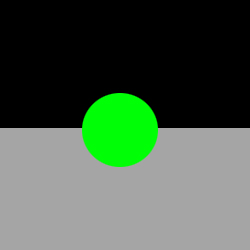

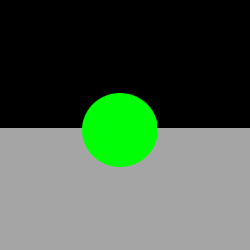

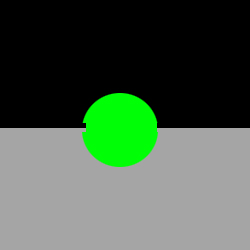

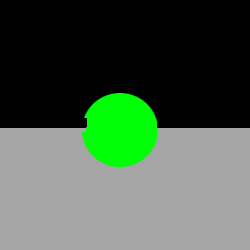

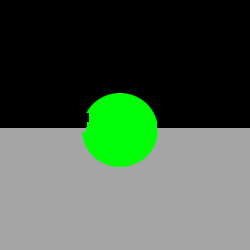

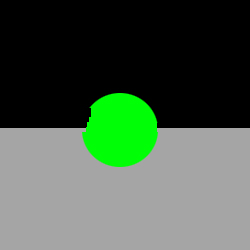

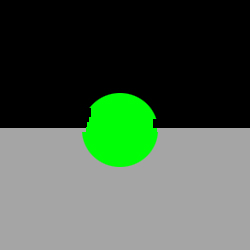

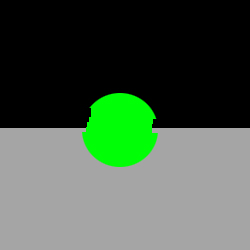

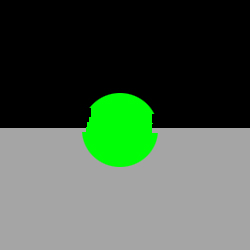

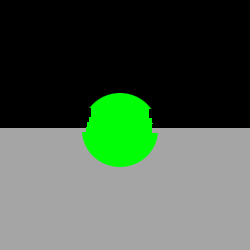

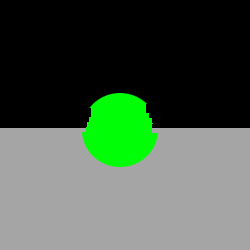

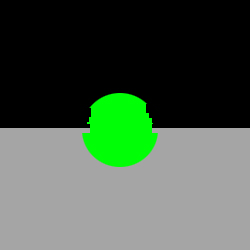

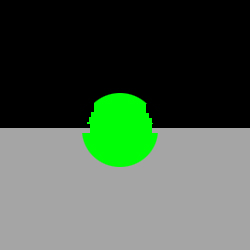

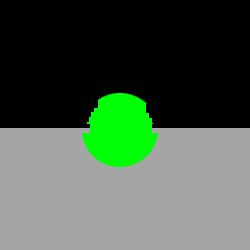

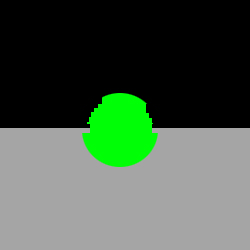

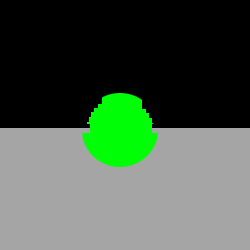

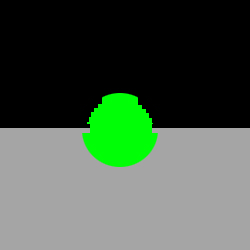

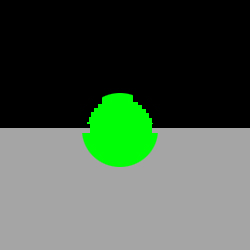

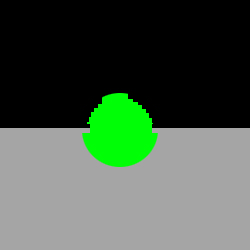

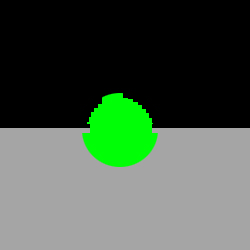

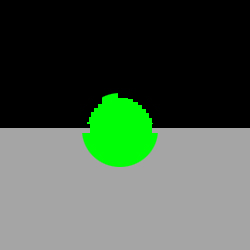

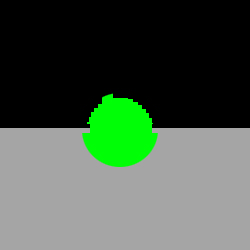

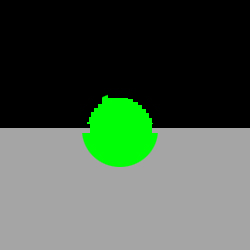

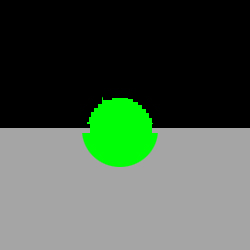

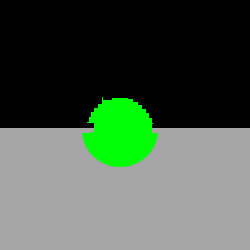

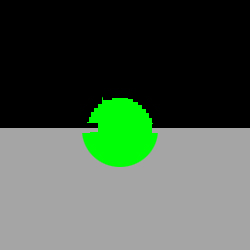

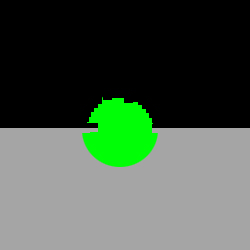

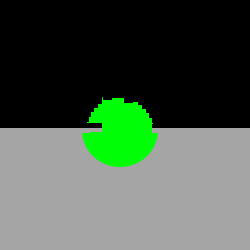

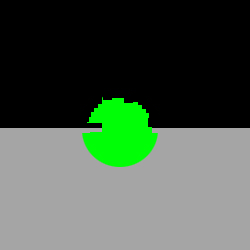

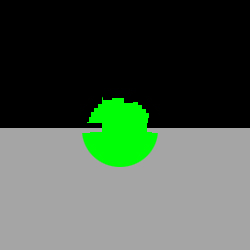

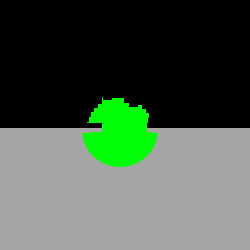

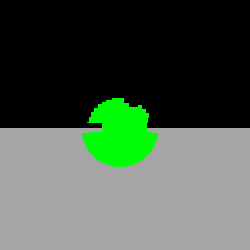

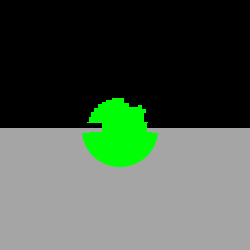

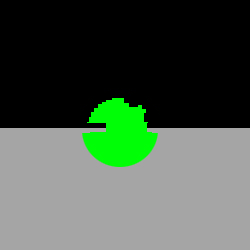

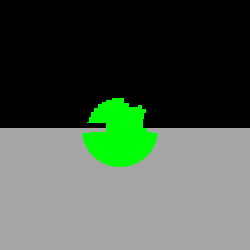

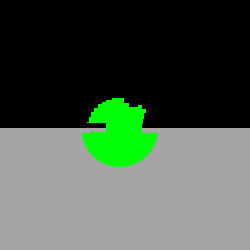

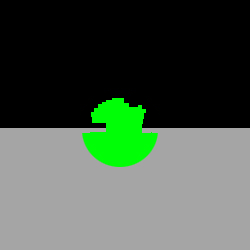

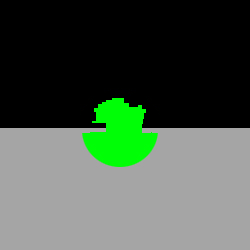

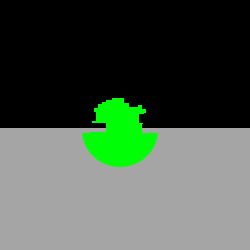

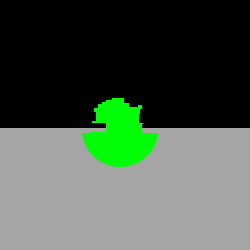

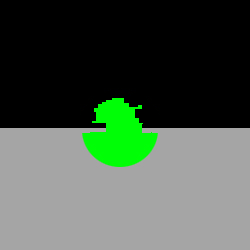

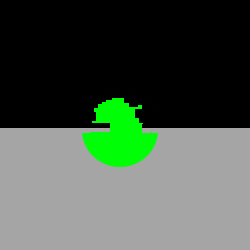

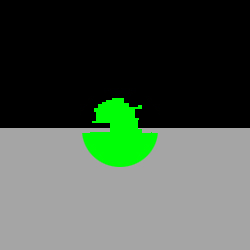

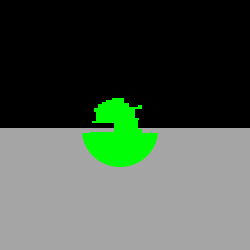

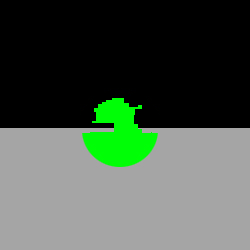

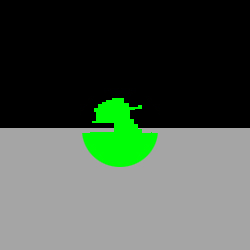

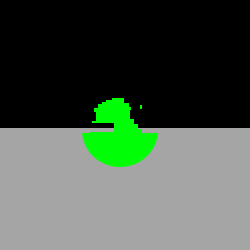

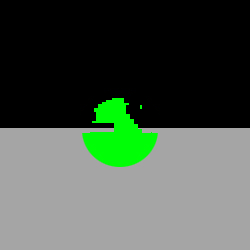

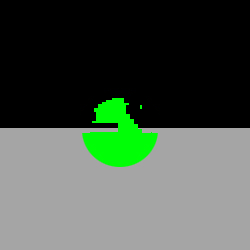

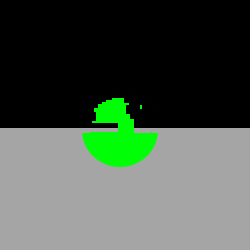

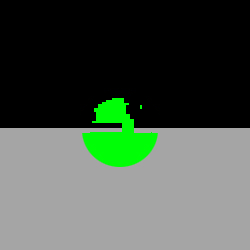

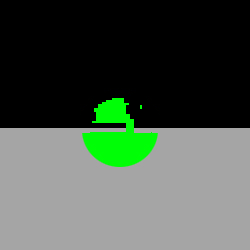

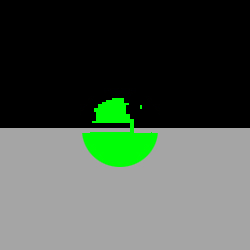

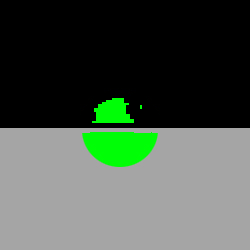

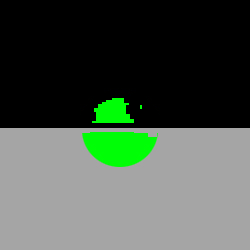

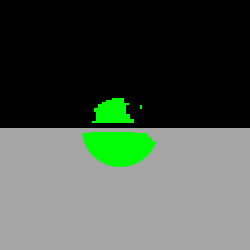

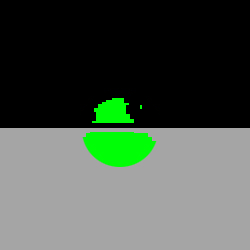

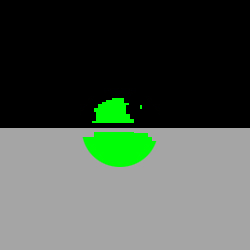

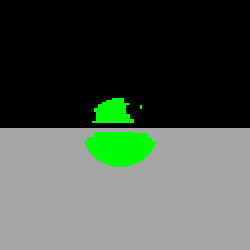

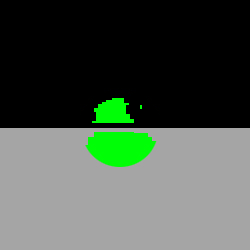

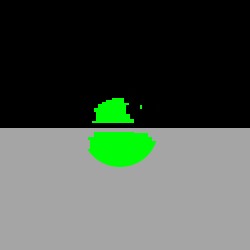

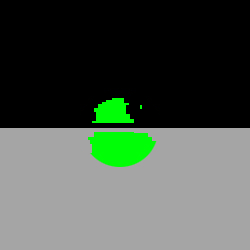

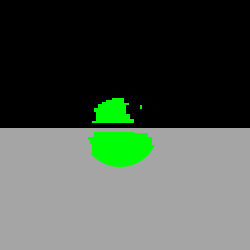

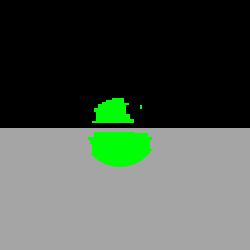

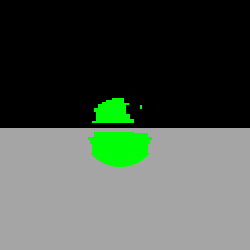

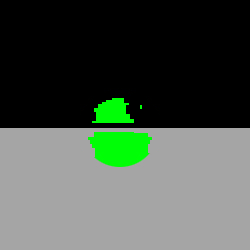

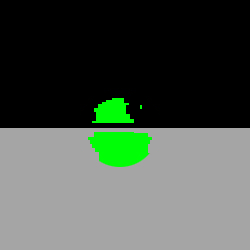

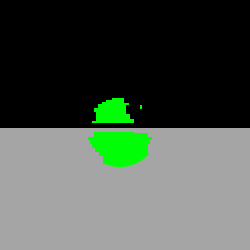

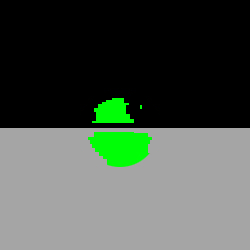

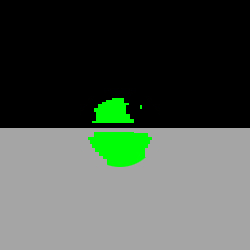

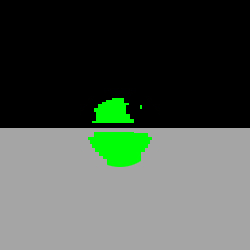

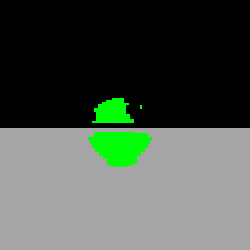

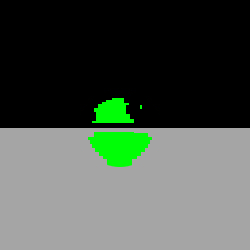

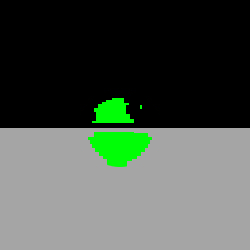

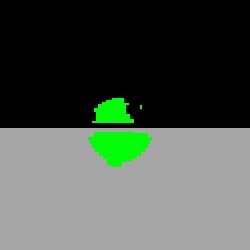

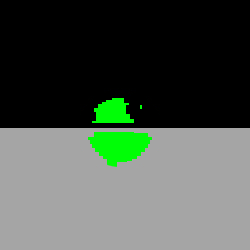

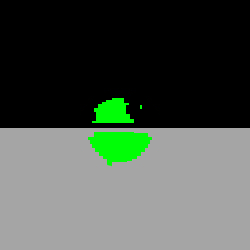

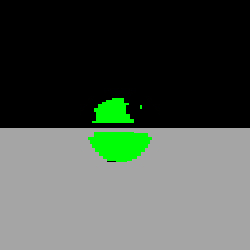

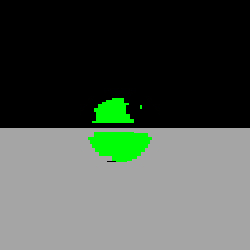

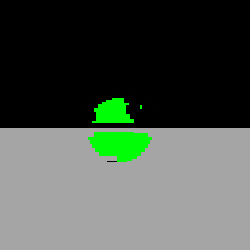

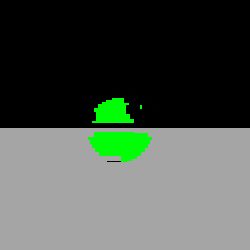

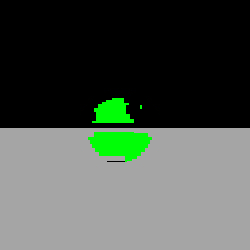

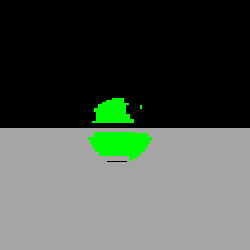

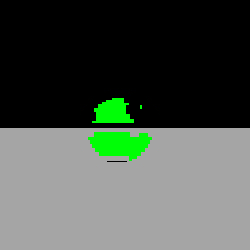

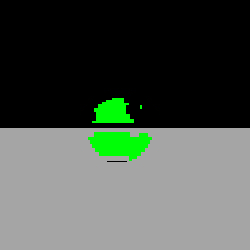

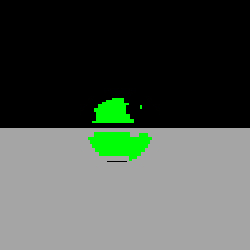

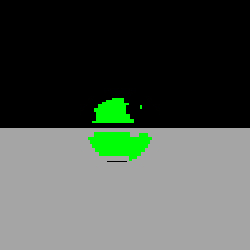

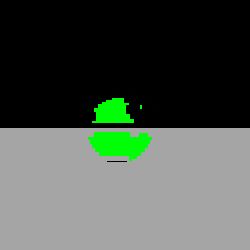

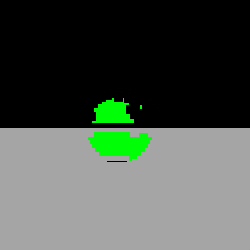

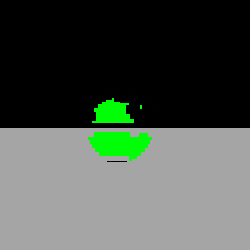

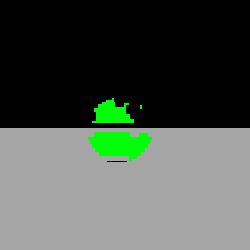

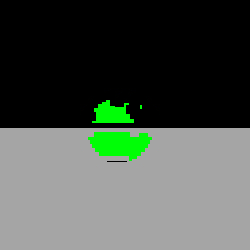

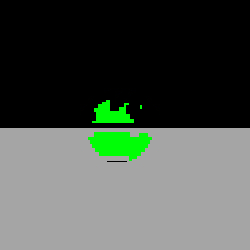

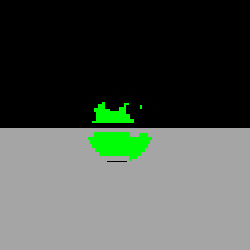

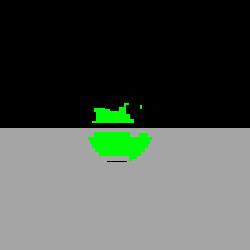

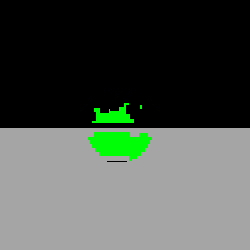

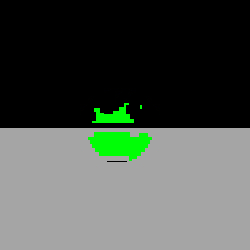

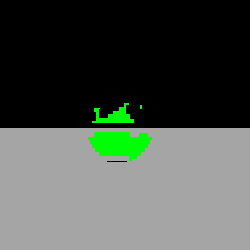

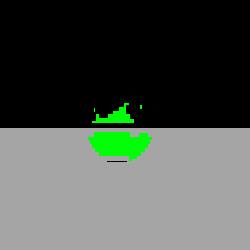

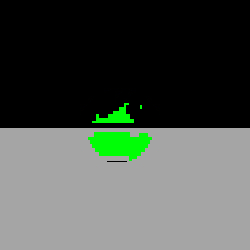

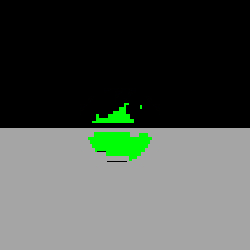

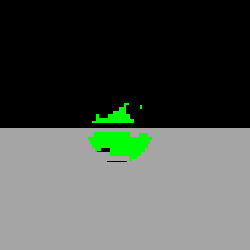

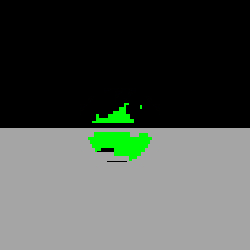

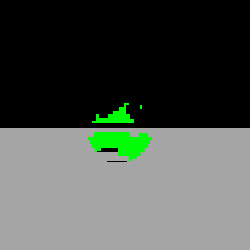

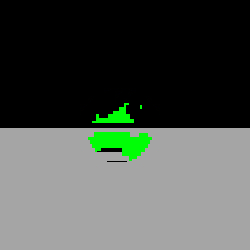

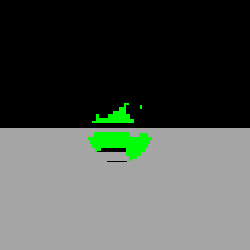

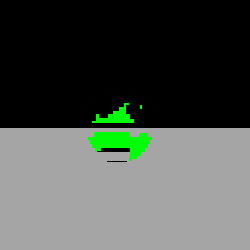

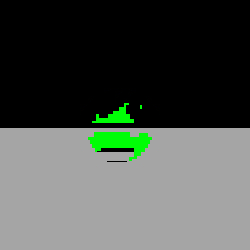

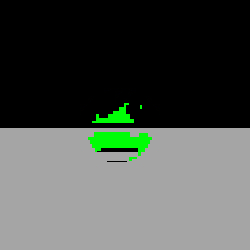

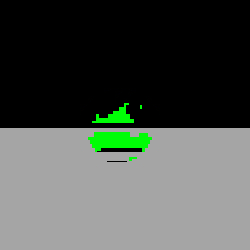

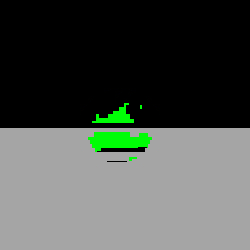

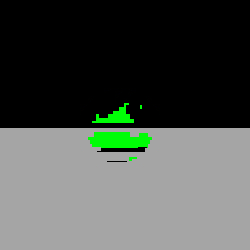

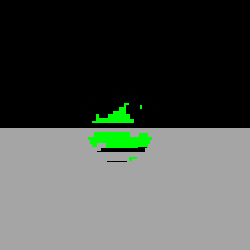

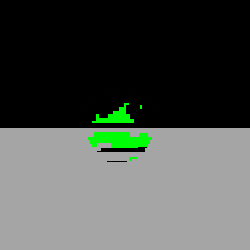

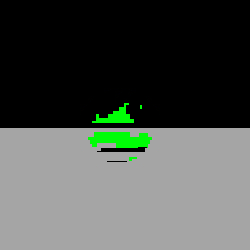

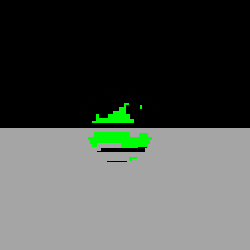

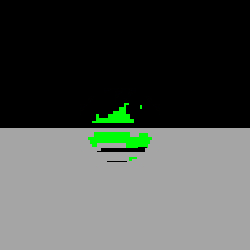

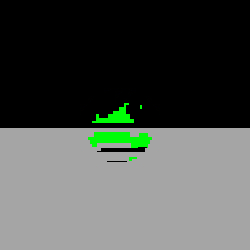

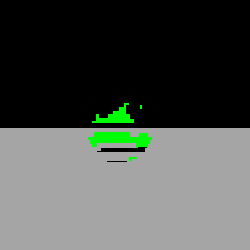

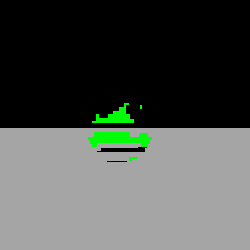

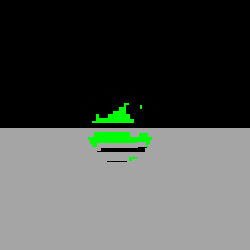

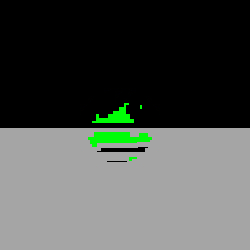

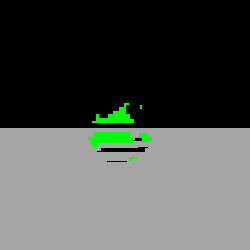

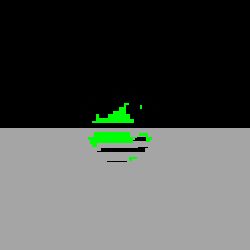

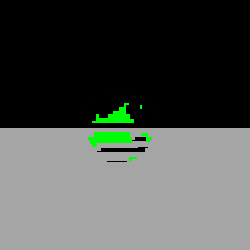

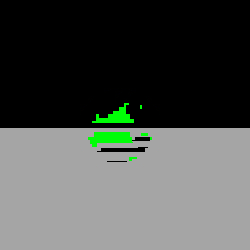

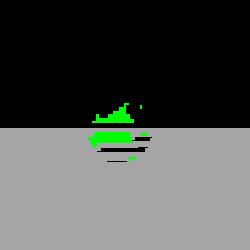

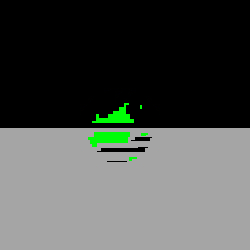

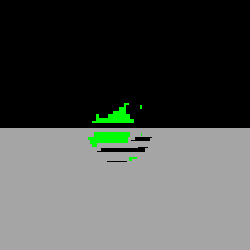

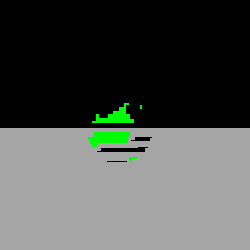

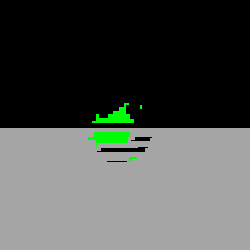

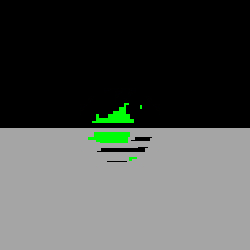

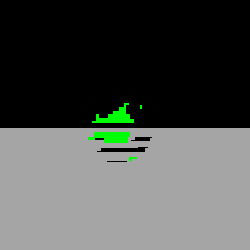

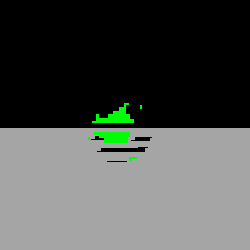

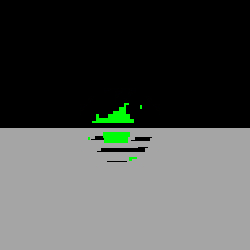

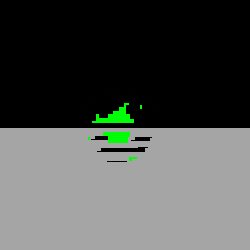

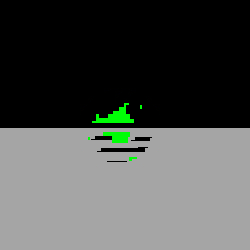

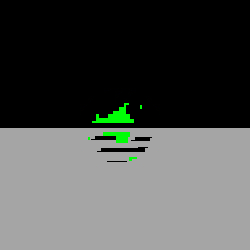

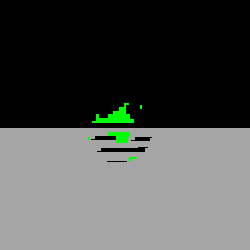

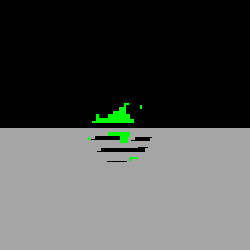

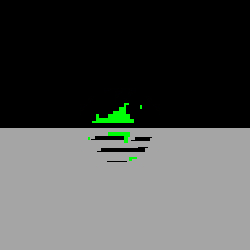

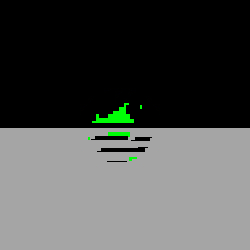

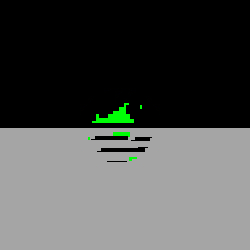

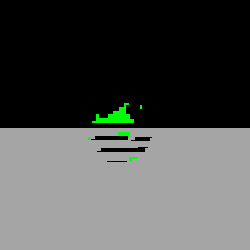

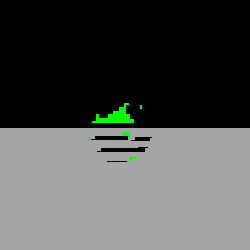

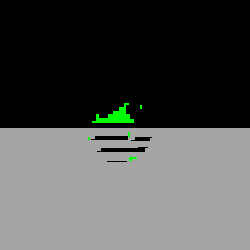

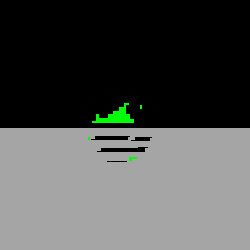

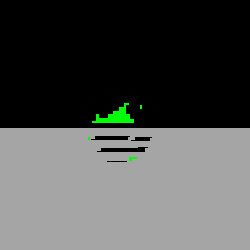

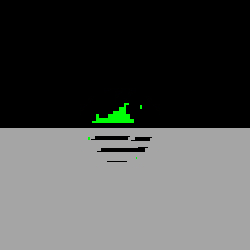

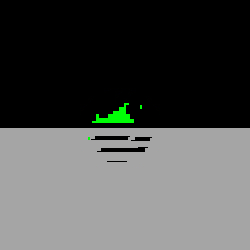

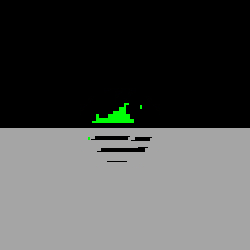

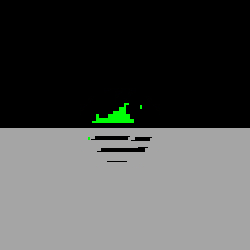

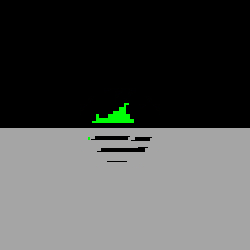

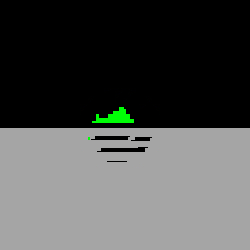

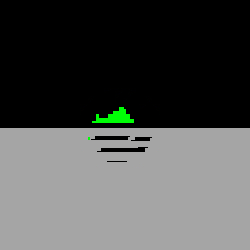

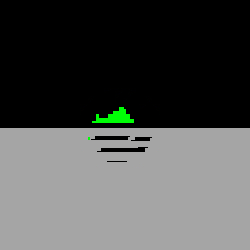

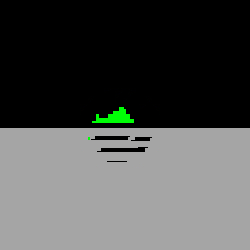

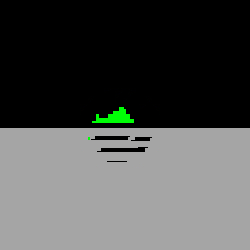

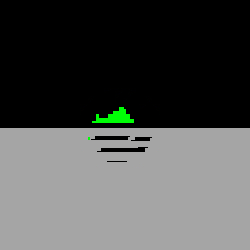

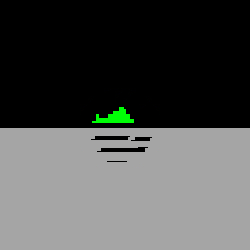

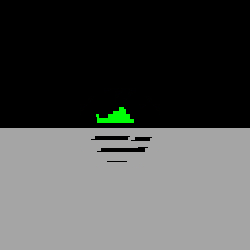

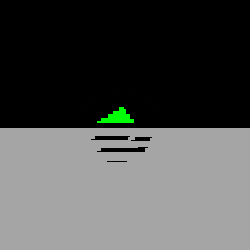

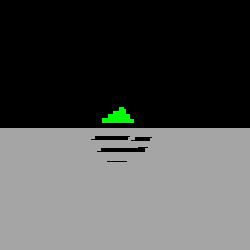

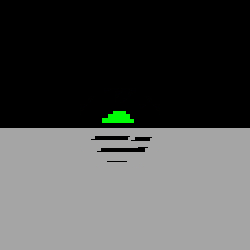

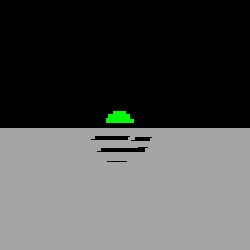

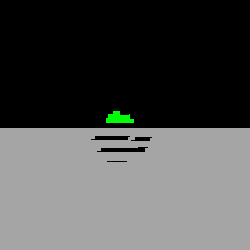

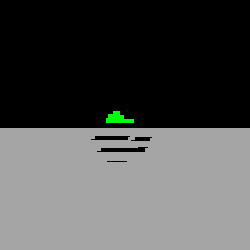

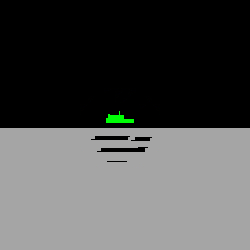

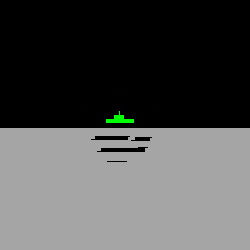

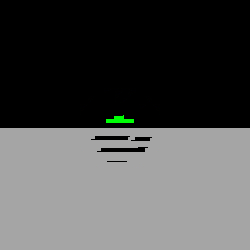

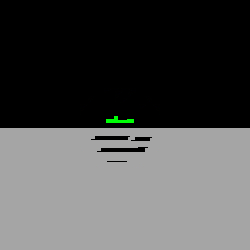

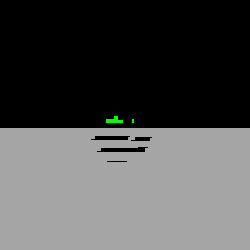

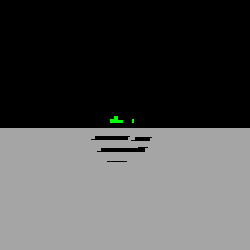

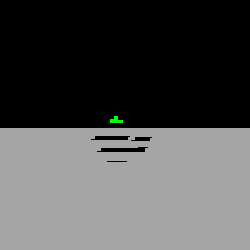

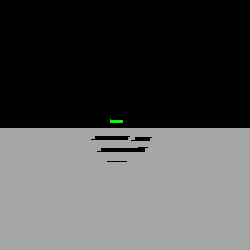

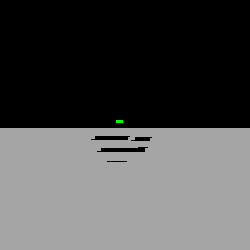

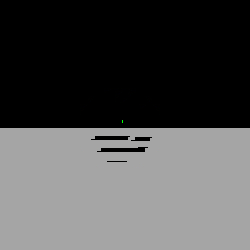

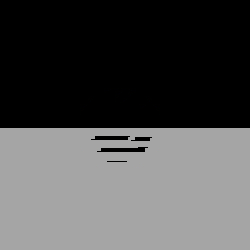

In [88]:
inpainting_obj = inpainting(test_image, test_mask)
inpainting_obj.do_inpainting()
# inpainting_obj.compute_priorities()
# inpainting_obj.update_image()